In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [6]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
m_data = data_all.query('age<100')

In [7]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [8]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
f_data = data_all.query('age<100')

In [9]:
# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])
#data.set_index('sex',inplace=True,append=True)

In [10]:
## pca male

In [11]:
pc = PCA(n_components=2)
#pc.fit(m_data)
pcs_male = pc.fit_transform(m_data)
pcm = pd.DataFrame(pcs_male)
pcm['psd'] = m_data.index.get_level_values('age')

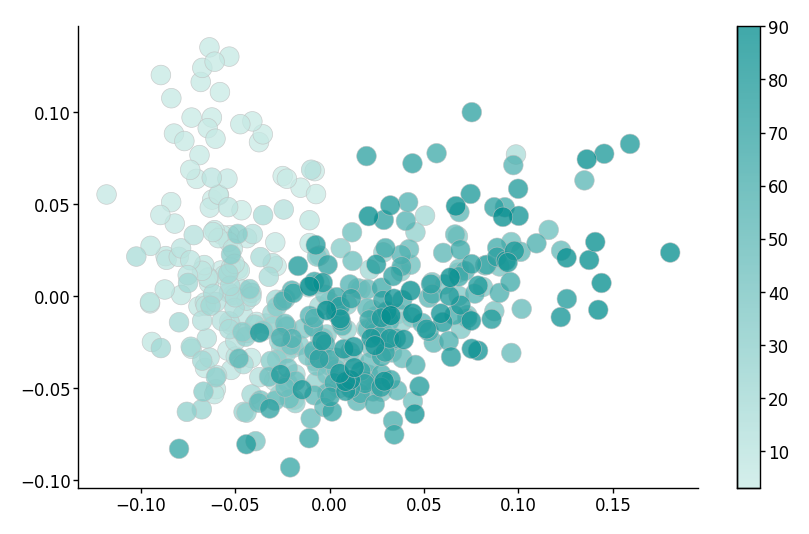

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3) 
im = plt.scatter(x=pcm[0], y=pcm[1], 
                cmap=cmm,
                s=50,
                edgecolor='silver',
                c=pcm['psd'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "simons"/ 'pca_male.pdf')

In [13]:
pc = PCA(n_components=2)
#pc.fit(m_data)
pcs_female = pc.fit_transform(f_data)
pcf = pd.DataFrame(pcs_female)
pcf['psd'] = f_data.index.get_level_values('age')

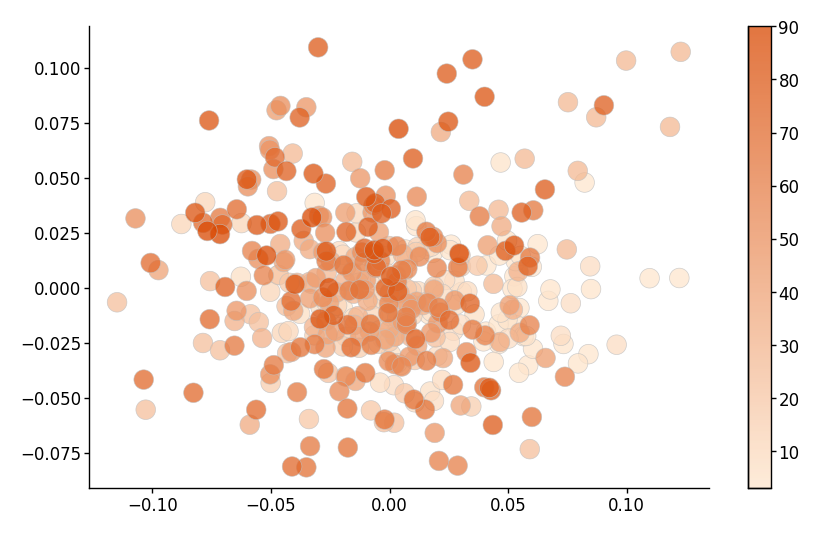

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3) 
im = plt.scatter(x=pcf[0], y=pcf[1], 
                cmap=cmf,
                s=50,
                edgecolor='silver',
                c=pcf['psd'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "simons"/ 'pca_female.pdf')

In [15]:
pc = PCA(n_components=2)
#pc.fit(m_data)
pcs_male = pc.fit_transform(m_data)
pcs_female = pc.transform(f_data)

pcm = pd.DataFrame(pcs_male)
pcm['psd'] = m_data.index.get_level_values('age')

pcf = pd.DataFrame(pcs_female)
pcf['psd'] = f_data.index.get_level_values('age')

In [16]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [17]:
cumulative_variance_explained

array([0.39380325, 0.60546939])

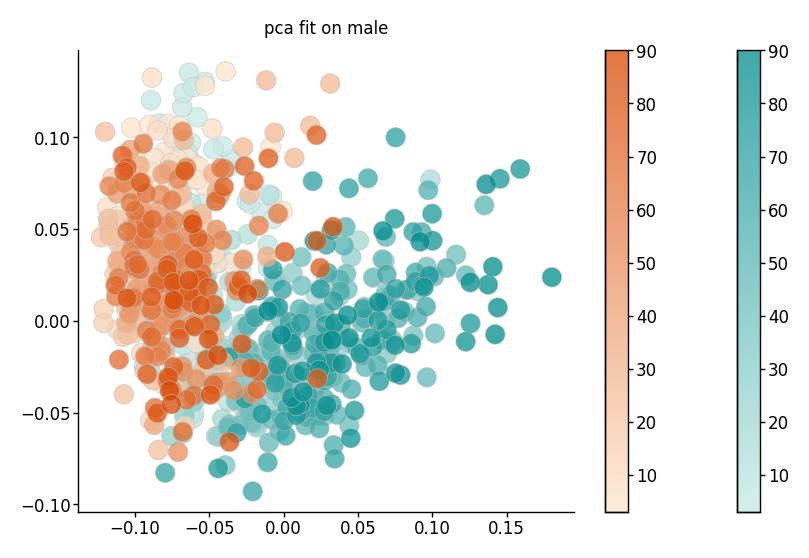

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3) 
im = plt.scatter(x=pcm[0], y=pcm[1], 
                cmap=cmm,
                s=50,
                edgecolor='silver',
                c=pcm['psd'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
im2=plt.scatter(x=pcf[0], y=pcf[1], 
                cmap=cmf,
                s=50,
                edgecolor='silver',
                c=pcf['psd'], 
                linewidth=0.25,
                #norm='log',
                alpha=0.75,
               )
cb=fig.colorbar(im2,ax=ax)
sns.despine()
c = PlotConfig()
plt.title('pca fit on male')
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_pca_fit_on_male.pdf')

In [19]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcm[0], pcm['psd'])
print(cm)
[cf,pf] = stats.spearmanr(pcf[0], pcf['psd'])
print(cf)

0.7449425279145341
0.18108127897749624


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


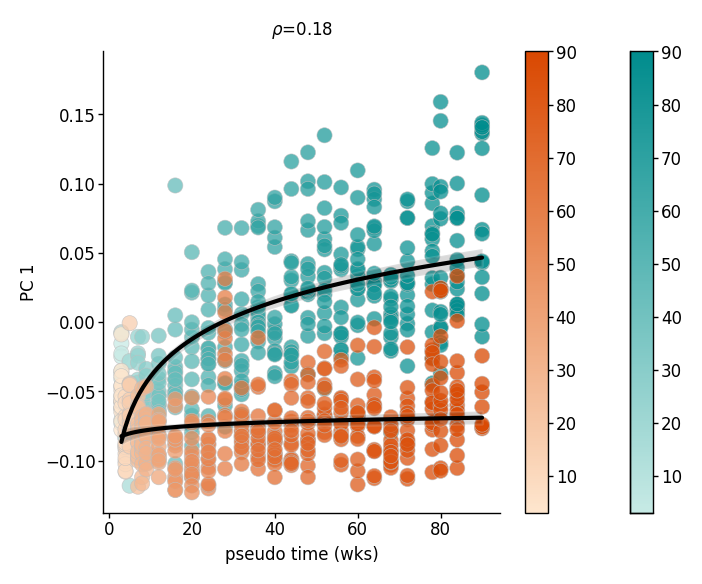

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=pcm['psd'], y=pcm[0], 
            s=30, 
            c=pcm['psd'], 
            edgecolor='silver',
            linewidth=0.25,
            norm='log',
            alpha=0.75,
            cmap=cmm)
ax = sns.regplot(data=pcm, x='psd', y=pcm[0], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC 1')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcm['psd'].min(), pcm['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

plt.scatter(x=pcf['psd'], y=pcf[0], 
            s=30, 
            c=pcf['psd'], 
            edgecolor='silver',
            linewidth=0.25,
            alpha=0.75,
            norm='log',
            cmap=cmf)
ax = sns.regplot(data=pcf, x='psd', y=pcf[0], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='pseudo time (wks)', ylabel='PC 1')
plt.title(f'$\\rho$={cf:0.2f}')
norm = plt.Normalize(pcf['psd'].min(), pcf['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)


c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_pca_corr.pdf')

In [21]:
## fit on both datasets

In [22]:
pc = PCA(n_components=2)
pc.fit(data)
pcs_male = pc.transform(m_data)
pcs_female = pc.transform(f_data)

pcm = pd.DataFrame(pcs_male)
pcm['psd'] = m_data.index.get_level_values('age')

pcf = pd.DataFrame(pcs_female)
pcf['psd'] = f_data.index.get_level_values('age')

In [23]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [24]:
cumulative_variance_explained

array([0.42525359, 0.61860456])

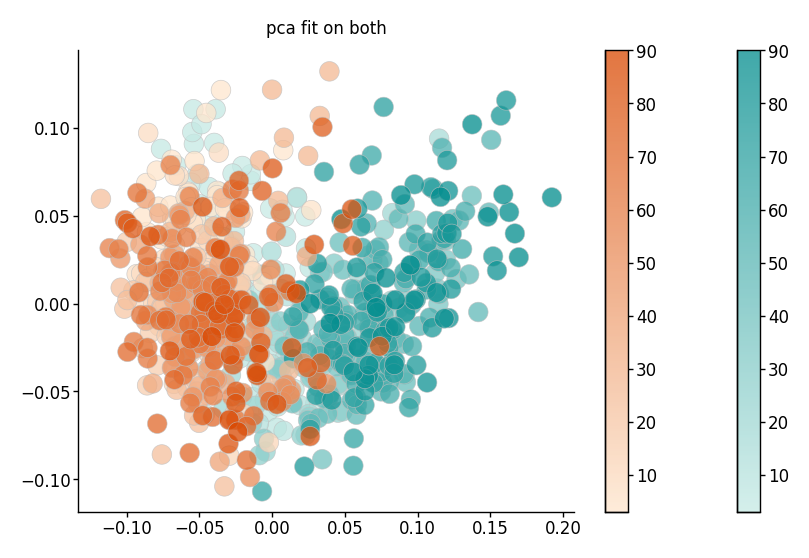

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3) 
im = plt.scatter(x=pcm[0], y=pcm[1], 
                cmap=cmm,
                s=50,
                edgecolor='silver',
                c=pcm['psd'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
im2=plt.scatter(x=pcf[0], y=pcf[1], 
                cmap=cmf,
                s=50,
                edgecolor='silver',
                c=pcf['psd'], 
                linewidth=0.25,
                #norm='log',
                alpha=0.75,
               )
cb=fig.colorbar(im2,ax=ax)
sns.despine()
c = PlotConfig()
plt.title('pca fit on both')
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_pca_fit_on_both.pdf')

In [26]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcm[0], pcm['psd'])
print(cm)
[cf,pf] = stats.spearmanr(pcf[0], pcf['psd'])
print(cf)

0.7600388274869577
0.1917798929227354


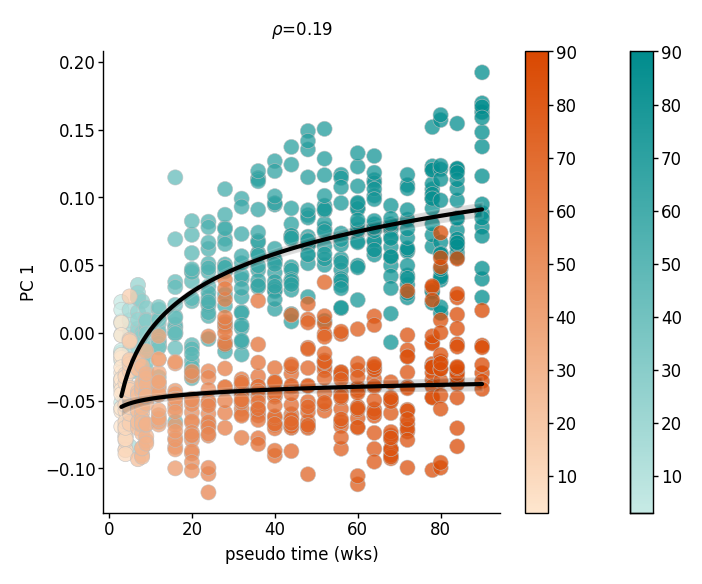

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=pcm['psd'], y=pcm[0], 
            s=30, 
            c=pcm['psd'], 
            edgecolor='silver',
            linewidth=0.25,
            norm='log',
            alpha=0.75,
            cmap=cmm)
ax = sns.regplot(data=pcm, x='psd', y=pcm[0], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC 1')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcm['psd'].min(), pcm['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

plt.scatter(x=pcf['psd'], y=pcf[0], 
            s=30, 
            c=pcf['psd'], 
            edgecolor='silver',
            linewidth=0.25,
            alpha=0.75,
            norm='log',
            cmap=cmf)
ax = sns.regplot(data=pcf, x='psd', y=pcf[0], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='pseudo time (wks)', ylabel='PC 1')
plt.title(f'$\\rho$={cf:0.2f}')
norm = plt.Normalize(pcf['psd'].min(), pcf['psd'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)


c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_pca_corr_fit_on_both.pdf')